In [1]:
import sys, os
import sparse
import xsimlab as xs
import xarray as xr
import numpy as np
import pandas as pd
import igraph as ig
from pgljupyter import SceneWidget

In [2]:
sys.path.insert(0, os.path.join(os.getcwd(), '..'))
import vmlab
from vmlab.models.vmango import vmango as model
from vmlab.enums import Nature

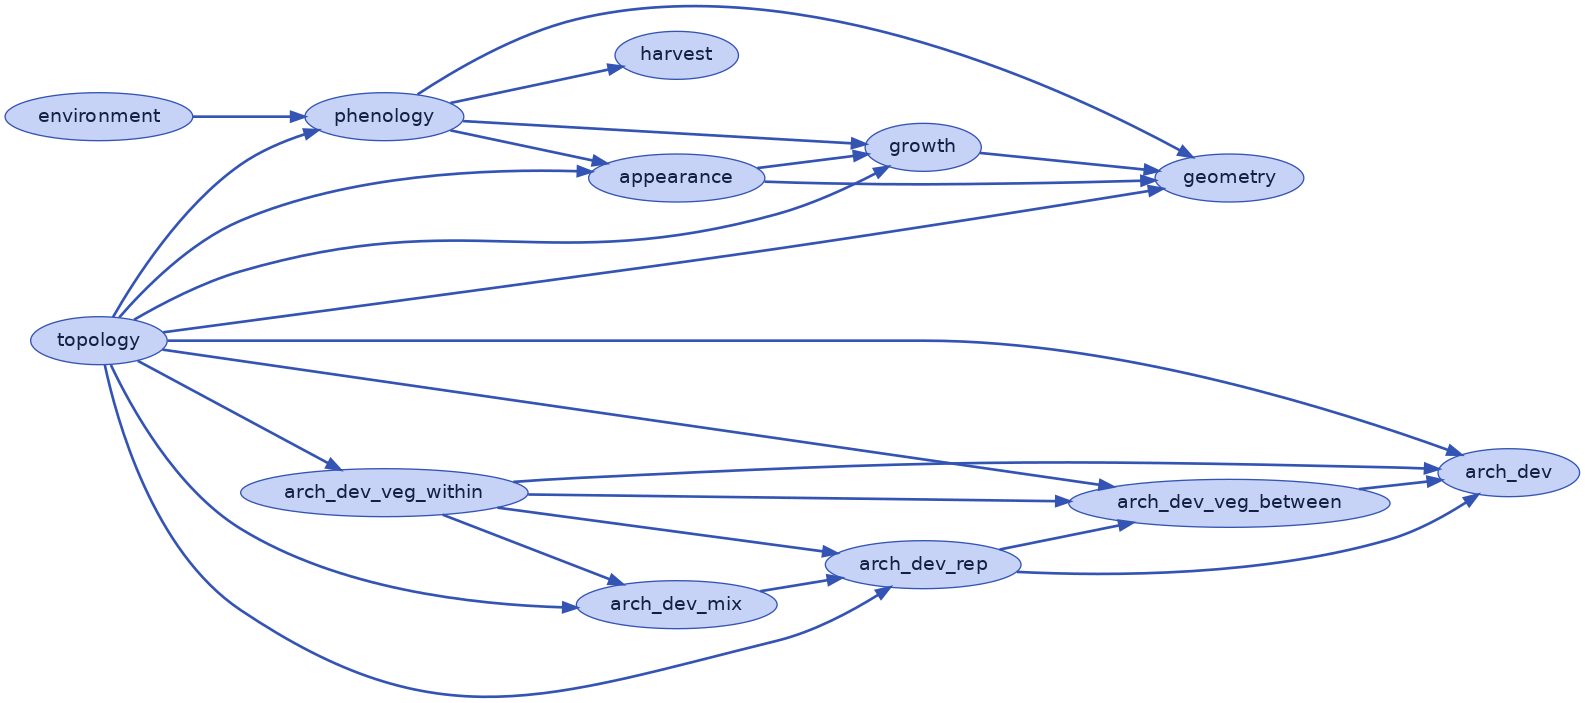

In [3]:
model = model.drop_processes(['light_interception', 'carbon_allocation', 'photosynthesis', 'carbon_reserve', 'carbon_demand', 'carbon_balance', 'fruit_quality'])
model.visualize()

In [4]:
tree = pd.DataFrame({
    'id': [0, 1, 2, 3],
    'parent_id': [np.nan, 0, 0, 0],
    'cycle': [3, 3, 3, 3],
    'is_apical': [1, 0, 0, 1],
    'appearance_month': [2, 2, 2, 2],
    'ancestor_nature': [0, 0, 0, 0],
    'ancestor_is_apical': [1, 1, 1, 1],
    'nature': [0, 0, 0, 0],
    'flowering_week': [0, 0, 0, 0],
    'nb_fruit': [0, 0, 0, 0],
    'nb_inflo': [0, 0, 0, 0]
})
tree

,id,parent_id,cycle,is_apical,appearance_month,ancestor_nature,ancestor_is_apical,nature,flowering_week,nb_fruit,nb_inflo
0,0,NaN,3,1,2,0,1,0,0,0,0
1,1,0.0,3,0,2,0,1,0,0,0,0
2,2,0.0,3,0,2,0,1,0,0,0,0
3,3,0.0,3,1,2,0,1,0,0,0,0


In [5]:
start_date='2003-06-01'
end_date='2006-06-01'
ds = vmlab.create_setup(
    model,
    initial_tree_df=None,
    start_date=start_date,
    end_date=end_date,
    setup_toml='../share/setup/vmango.toml',
    current_cycle=3,
    input_vars={
        'topology': {
            'seed': 66,
            'month_begin_veg_cycle': 7,
            'doy_begin_flowering': 214
        },
        'geometry__interpretation_freq': -1
    },
    output_vars=None
)

In [6]:
sw = SceneWidget(size_world=2.5)
sw

SceneWidget(scenes=[{'id': 'wGKJ3iX1uoTAh7mOmcVCGSYm1', 'data': b'x\xdaSLrw\xf5\xf7e`Pp\xe0\xe5RPVVd\x00\x020\…

In [7]:
scene_ = None
@xs.runtime_hook(stage='run_step')
def hook(model, context, state):
    global scene_
    scene = state[('geometry', 'scene')]
    if scene != scene_:
        sw.set_scenes([scene], scales=[1/100])
        scene_ = scene
    
ds_out = ds.xsimlab.run(model=model, decoding={ 'mask_and_scale': False }, hooks=[xs.monitoring.ProgressBar(), hook])
ds_out

             0% | initialize 

<xarray.Dataset>
Dimensions:                                             (GU: 1713, day: 1097, hour: 24)
Coordinates:
  * GU                                                  (GU) <U10 'GU0' ... '...
  * day                                                 (day) datetime64[ns] ...
  * hour                                                (hour) int8 0 1 ... 23
Data variables: (12/92)
    appearance__appeared                                (GU) float32 1.0 ... 1.0
    appearance__final_length_gu                         (GU) float32 11.61 .....
    appearance__final_length_inflos                     (GU) object None ... ...
    appearance__final_length_internodes                 (GU) object [1.139818...
    appearance__final_length_leaves                     (GU) object [26.17533...
    appearance__nb_internode                            (GU) float32 12.0 ......
    ...                                                  ...
    topology__month_begin_veg_cycle                     int64 7
    topology__nb_descendants                            (GU) int64 1260 ... 0
    topology__nb_gu                                     int64 1713
    topology__parent_is_apical                          (GU) float32 1.0 ... 1.0
    topology__seed                                      int64 66
    topology__sim_start_date                            datetime64[D] 2003-06-01

<AxesSubplot:>

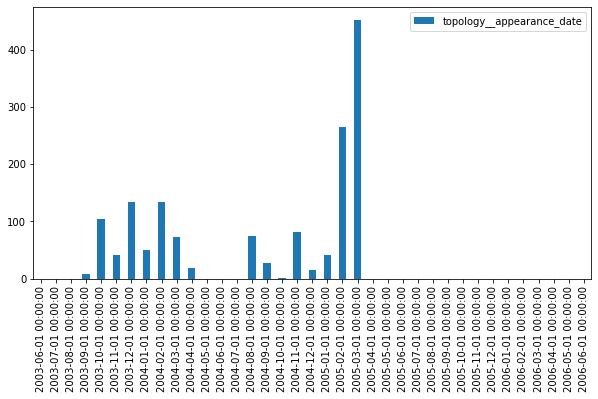

In [8]:
appearance_date = ds_out.topology__appearance_date.groupby(ds_out.topology__appearance_date)
appearance_date.count().to_dataframe().reindex(pd.date_range(start=start_date, end=end_date, freq='MS')).plot.bar(figsize=(10,5))

<AxesSubplot:>

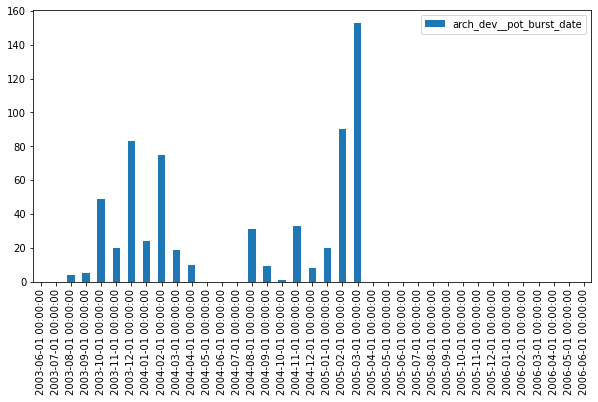

In [9]:
pot_burst_date = ds_out.arch_dev__pot_burst_date.groupby(ds_out.arch_dev__pot_burst_date)
pot_burst_date.count().to_dataframe().reindex(pd.date_range(start=start_date, end=end_date, freq='MS')).plot.bar(figsize=(10,5))

<AxesSubplot:xlabel='arch_dev__pot_flowering_date'>

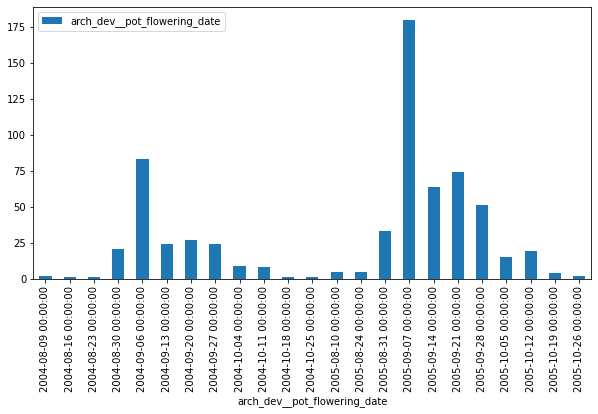

In [10]:
pot_flowering_date = ds_out.arch_dev__pot_flowering_date.groupby(ds_out.arch_dev__pot_flowering_date)
pot_flowering_date.count().to_dataframe().plot.bar(figsize=(10,5))

<AxesSubplot:xlabel='phenology__nb_inflo'>

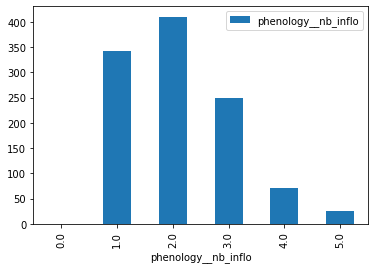

In [11]:
topology__nb_inflo = ds_out.phenology__nb_inflo.groupby(ds_out.phenology__nb_inflo)
topology__nb_inflo.sum().to_dataframe().plot.bar()

<AxesSubplot:xlabel='harvest__nb_fruit_harvested'>

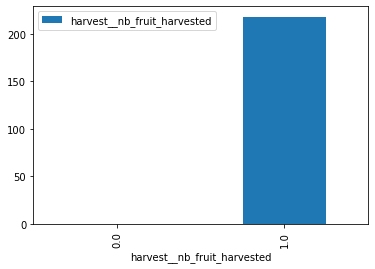

In [19]:
nb_fruit = ds_out.harvest__nb_fruit_harvested.groupby(ds_out.harvest__nb_fruit_harvested)
nb_fruit.sum().to_dataframe().plot.bar()

<AxesSubplot:xlabel='nb_children'>

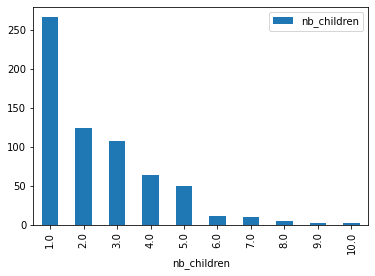

In [13]:
nb_children = xr.DataArray(ds_out.arch_dev__pot_has_apical_child + ds_out.arch_dev__pot_nb_lateral_children, name='nb_children')
nb_children = nb_children[nb_children > 0]
nb_children.groupby(nb_children).count().to_dataframe().plot.bar()

In [14]:
nb_children = xr.DataArray(ds_out.arch_dev__pot_has_apical_child + ds_out.arch_dev__pot_nb_lateral_children, name='nb_children')
ds_children = xr.Dataset({
    'nb_children':  nb_children[nb_children > 0], 
    'cycle': ds_out.topology__cycle[nb_children > 0]
})
ds_children

<xarray.Dataset>
Dimensions:      (GU: 640)
Coordinates:
  * GU           (GU) <U10 'GU9' 'GU12' 'GU14' ... 'GU1158' 'GU1183' 'GU1184'
Data variables:
    nb_children  (GU) float32 1.0 5.0 1.0 3.0 5.0 1.0 ... 2.0 1.0 1.0 4.0 4.0
    cycle        (GU) float32 3.0 3.0 3.0 3.0 3.0 3.0 ... 5.0 5.0 5.0 5.0 5.0

<AxesSubplot:xlabel='cycle'>

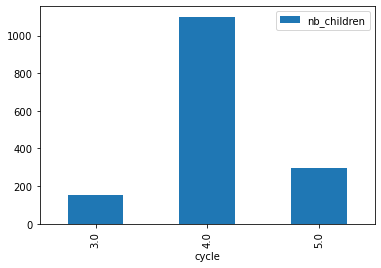

In [15]:
ds_children.groupby(ds_children.cycle).sum().to_dataframe().plot.bar()

<AxesSubplot:xlabel='topology__cycle'>

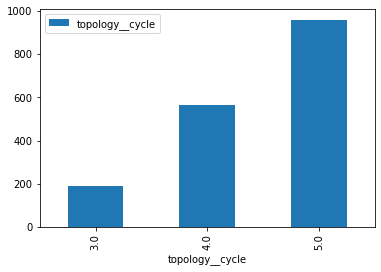

In [16]:
cycle = ds_out.topology__cycle.groupby(ds_out.topology__cycle)
cycle.count().to_dataframe().plot.bar()

<AxesSubplot:xlabel='arch_dev_veg_between__burst_date_children_between'>

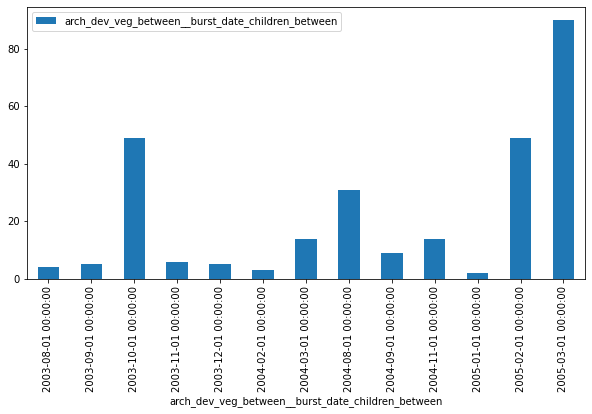

In [17]:
burst_date_children_between = ds_out.arch_dev_veg_between__burst_date_children_between.groupby(ds_out.arch_dev_veg_between__burst_date_children_between)
burst_date_children_between.count().to_dataframe().plot.bar(figsize=(10,5))

<AxesSubplot:xlabel='arch_dev_veg_within__burst_date_children_within'>

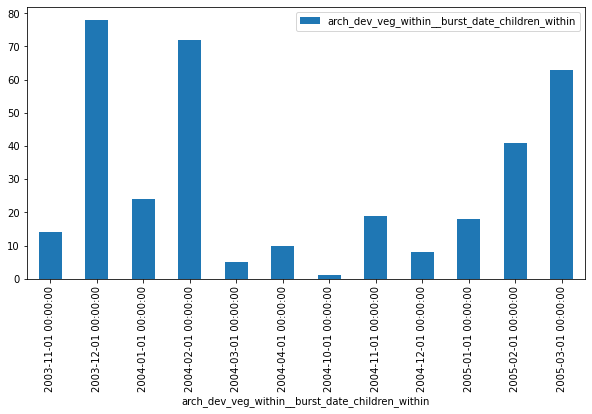

In [18]:
burst_date_children_within = ds_out.arch_dev_veg_within__burst_date_children_within.groupby(ds_out.arch_dev_veg_within__burst_date_children_within)
burst_date_children_within.count().to_dataframe().plot.bar(figsize=(10,5))